<div style="text-align: right">INFO 6105 Data Sci Engineering Methods and Tools, Week 7 Homework</div>
<div style="text-align: right">Dino Konstantopoulos, 25 February 2023</div>

# Airlines, love them or leave them

<br />
<center>
    <img src="plane-bird.jpg" width=600 />
</center>

Let's try to model the customer support for various well-known airlines.

I will attempt to model one of the relevant distributions in the dataset, and you will try to improve my model.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
%matplotlib inline 

from IPython.display import Image
import arviz as az
import pymc3 as pm 
import scipy 
import scipy.stats as stats 
import scipy.optimize as opt
import statsmodels.api as sm 

In [2]:
airlines = pd.read_csv(r'airlines.csv')

The dataset enumerates conversations between users and airlines, and records when the conversation took place and how long it took for the airline to respond to the customer inquiry.

We will model inquiry response time as a representative distribution of the quality of customer service.

In [3]:
airlines.sample(n = 20)

,Unnamed: 0,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,res_time,created_at_y_dayofweek,created_at_y_day_of_week,created_at_y_day,created_at_y_is_weekend,word_count
48684,485368,526354,2017-11-07 14:38:39,@British_Airways would I be able to speak to ...,British_Airways,2017-11-07 15:02:15,"@526354 Hi, Claire, we can look to help. Is it...",23.600000,1,Tuesday,7,0,24
21603,220202,314182,2017-11-05 13:02:19,So when're you going to stop the practice of o...,Delta,2017-11-05 14:02:17,"@314182 John, please accept our apology for an...",59.966667,6,Sunday,5,1,18
67604,695334,151682,2017-11-14 12:51:08,I️ do LOVE that @JetBlue will turn you away if...,JetBlue,2017-11-14 13:03:56,"@151682 Hi, Clara. We do believe this boarding...",12.800000,1,Tuesday,14,0,32
15018,160656,122918,2017-12-03 20:40:44,Back in CHA. Good job @AmericanAir Great fligh...,AmericanAir,2017-12-03 20:43:35,@122918 It was our pleasure to have you fly wi...,2.850000,6,Sunday,3,1,24
15549,165225,266314,2017-11-02 20:41:10,@824 I had been upgraded on both flights 2day ...,Delta,2017-11-02 20:46:05,"@266314 Hi Erik, thanks for contacting us. Th...",4.916667,3,Thursday,2,0,26
38427,378970,423138,2017-10-28 03:57:38,"@JetBlue Hey guys, who can I contact about spo...",JetBlue,2017-10-28 04:03:39,@423138 Hi Kymberly. Send us a DM and we can p...,6.016667,5,Saturday,28,1,16
66566,683794,681379,2017-11-13 20:02:16,@Delta love the level of service by the gate a...,Delta,2017-11-13 20:02:47,@681379 Hi Nick. I am so sorry for the experie...,0.516667,0,Monday,13,0,20
17303,180997,280382,2017-11-23 08:58:33,Hey @Delta we are at IND and no one at desks. ...,Delta,2017-11-23 09:01:30,"@280382 Hi, Lish. One of our agents will be ri...",2.950000,3,Thursday,23,0,18
49239,491788,343236,2017-11-07 22:22:58,@SouthwestAir BY FAR has the best customer ser...,SouthwestAir,2017-11-07 22:28:02,@343236 We love having you as a Customer and f...,5.066667,1,Tuesday,7,0,21
68441,705413,697769,2017-11-14 20:25:52,@SouthwestAir what is your policy with garment...,SouthwestAir,2017-11-14 20:32:48,"@697769 If carryon, the garment bag would coun...",6.933333,1,Tuesday,14,0,27


# 1. Question 1

Let's plot the historgram of response time:

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


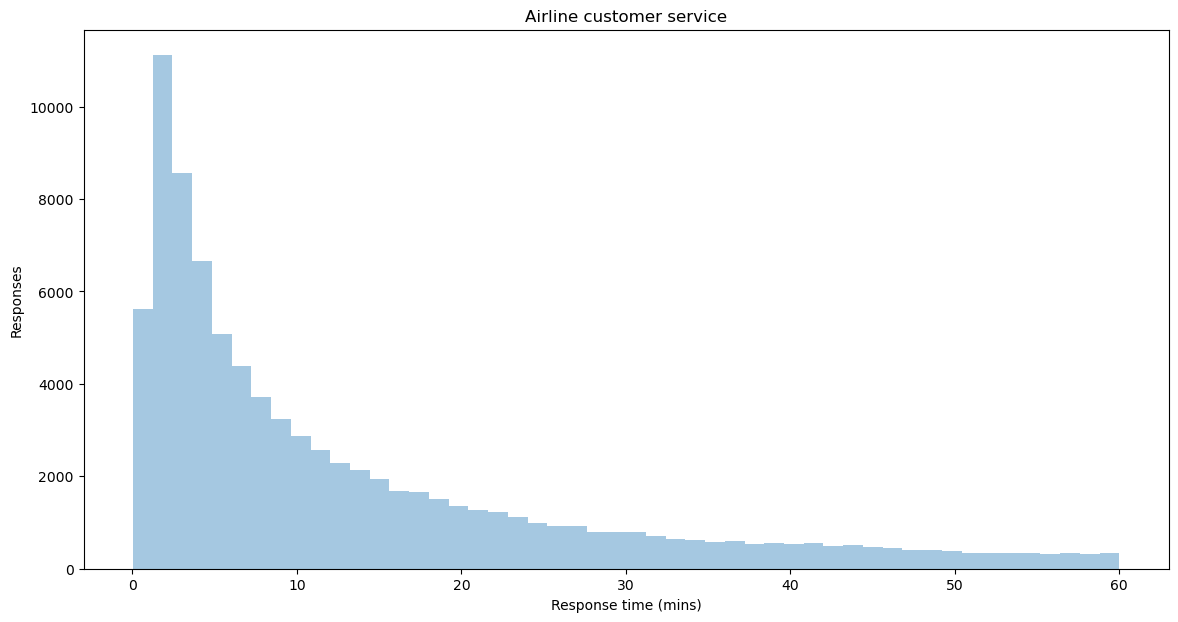

In [4]:
plt.figure(figsize = (14, 7))
sns.distplot(airlines['res_time'], kde = False)
plt.title('Airline customer service')
plt.xlabel('Response time (mins)')
plt.ylabel('Responses');

# Modeling with a Student-t data likelihood
A good option when dealing with outliers is to replace the Gaussian likelihood with a Student t-distribution. 

The Student-t has three parameters: the mean $\mu$, the scale $\sigma$ (analogous to the standard deviation), and the degrees of freedom $\nu$.

For a value of $ν = 1$, we get a distribution with heavy tails, with more outliers than a Gaussian.

We model the response time with a Student-t:

In [5]:
with pm.Model() as model1:
    mu = pm.Uniform('mu', lower = 0, upper = 60) 
    sd = pm.HalfNormal('sd', sd = 10)
    e = pm.Exponential('e', 1/1) 
    t = pm.StudentT('t', mu = mu, sd = sd, nu = e, observed = airlines['res_time'])

In [6]:
with model1:
    trace = pm.sample(2000, tune=2000)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e, sd, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 88 seconds.


Let's plot our model parameter posteriors:

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


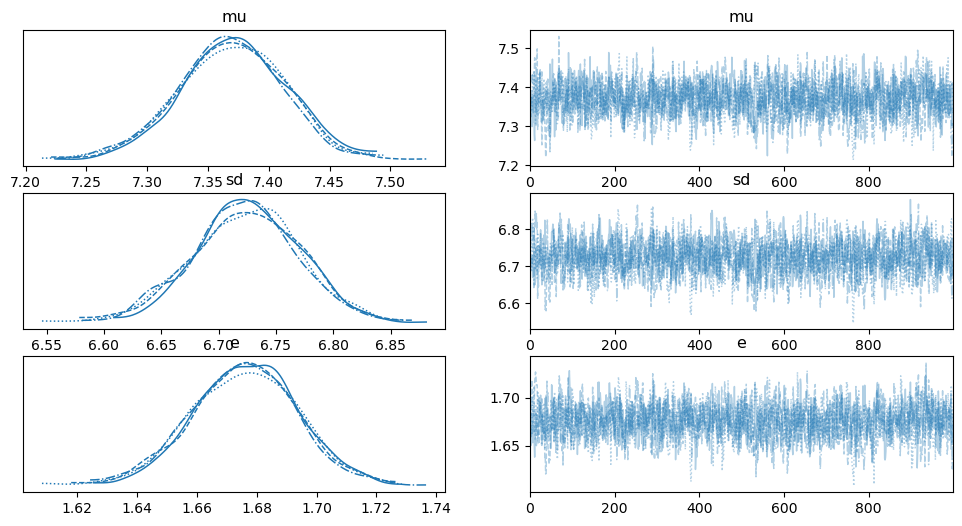

In [7]:
az.plot_trace(trace[:1000], var_names = ['mu', 'sd', 'e']);

To infer how close the posteriors are to the actual observation, we are going to sample from the posterior predictive (to create "fake" data), and then we are going to compare the hsitogram of the fake data to the empirical histogram.

In [8]:
ppc = pm.sample_posterior_predictive(trace, samples = 1000, model = model1)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [9]:
ppc

{'t': array([[  2.52393231,  12.48469526,  44.23493519, ...,  19.43820306,
          13.30678368,  14.97423392],
        [  4.15999868,   5.59640948,  32.66917708, ...,   8.95214723,
           4.06701515, -13.61948051],
        [  4.80169613,   9.16978321,  23.03670691, ...,  -0.22805492,
          -2.64066284,  -0.92751842],
        ...,
        [  8.74408398, -46.94956729,  -0.84144831, ...,   7.19856697,
           4.71308487,   1.16646694],
        [  3.12419694, -19.50848639,  14.72048618, ...,   1.61784969,
           9.11076058,  -7.34312435],
        [  4.03061016,   6.55454696,  12.22415892, ...,  11.46112901,
           8.83657527,  11.48396886]])}

Let's plot the histogram of the empirical response time and its mean:

[Text(0.5, 1.0, 'Empirical histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

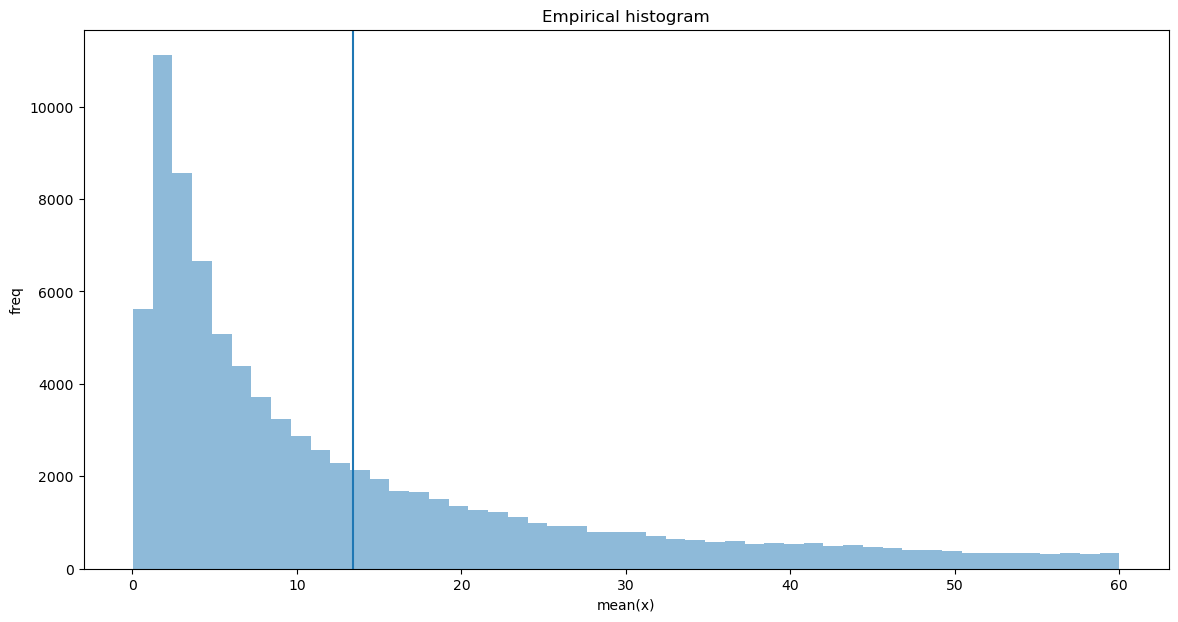

In [10]:
_, ax = plt.subplots(figsize = (14, 7))
plt.hist(airlines['res_time'], bins = 50, alpha = 0.5)
ax.axvline(airlines['res_time'].mean())
ax.set(title = 'Empirical histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

Let's plot the histogram of the model-simulated response time and the empirical mean:

[Text(0.5, 1.0, 'Simulated histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

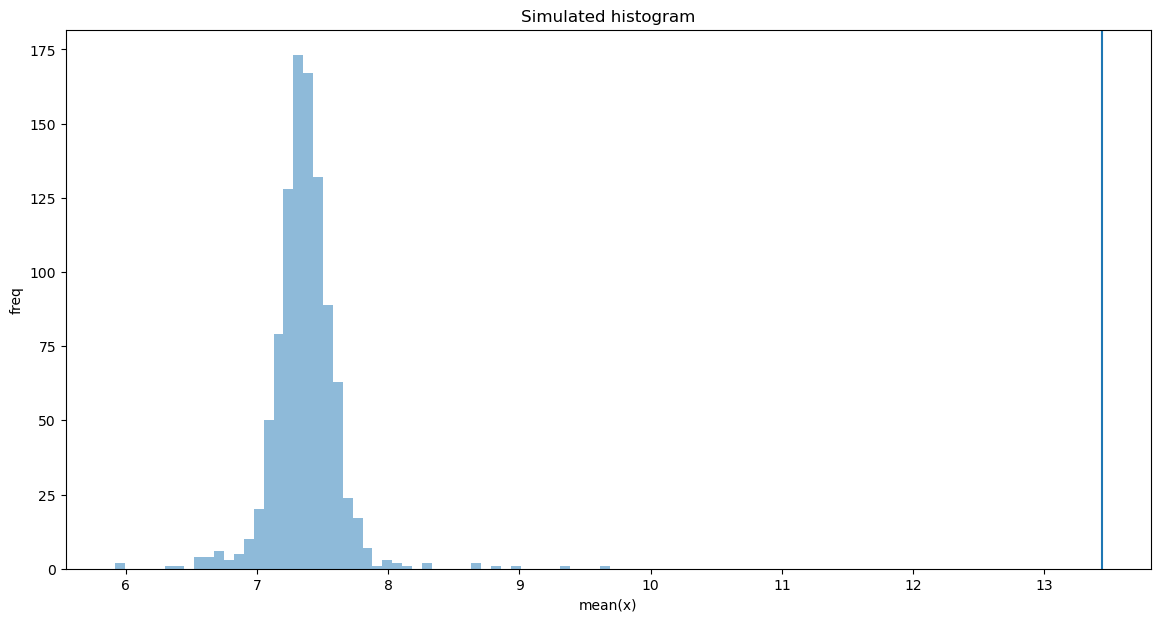

In [11]:
_, ax = plt.subplots(figsize = (14, 7))

ax.hist([n.mean() for n in ppc['t']], bins = 50, alpha = 0.5)
ax.axvline(airlines['res_time'].mean())
ax.set(title = 'Simulated histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

They don't match! In fact, the model seems to tell us that the mean of the distribution should be between 7.2 and 7.4.

In [12]:
with model1:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,7.37,0.04,7.29,7.45,0.0,0.0,2239.95,3274.20,1.0
sd,6.72,0.05,6.64,6.81,0.0,0.0,2126.89,2781.97,1.0
e,1.68,0.02,1.64,1.71,0.0,0.0,2148.72,2763.65,1.0


But taht's not even close! The empirical mean is: 

In [13]:
airlines['res_time'].mean()

13.436461105326302

# Homework question 1
Can you fix what professor did wrong in building the model?

In [14]:
res = airlines['res_time']
with pm.Model() as model3:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    nmd = pm.Normal('nmd', mu = mu, sd = sd, observed = res[(res >= 0) & (res < 10)])
    alpha = pm.HalfNormal('alpha', sigma=10)
    nu = pm.HalfNormal('nu', sigma=10)
    nb = pm.NegativeBinomial('nb', mu = alpha, alpha = nu, observed=res[(res >= 10)]) 
    

In [15]:
with model3:
    trace3 = pm.sample(1000, tune = 1000)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, alpha, sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


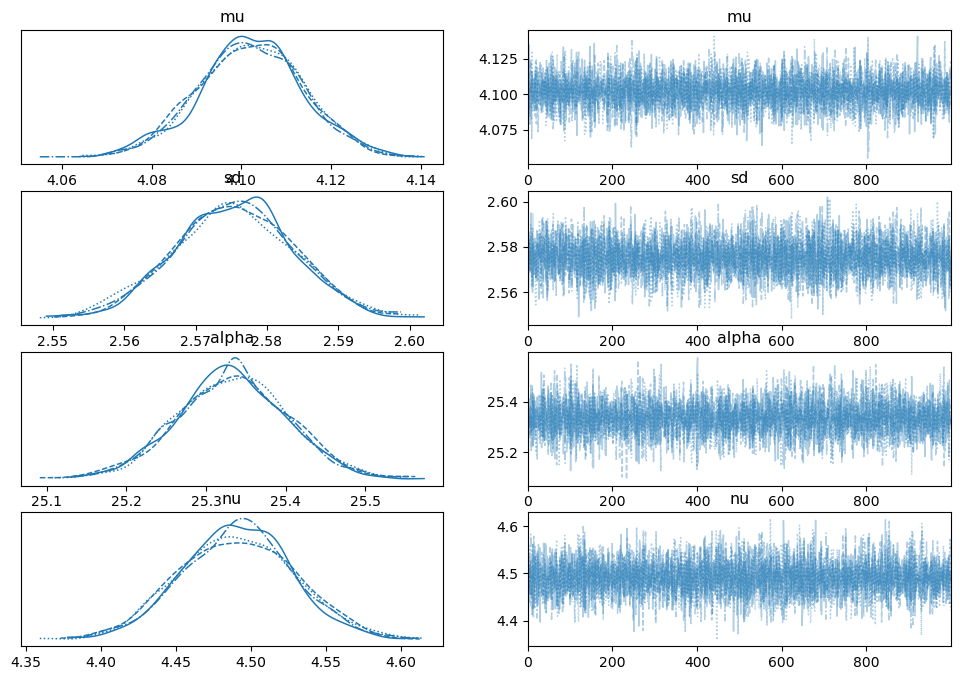

In [16]:
az.plot_trace(trace3[:1000], var_names = ['mu', 'sd', 'alpha','nu']);

In [17]:
ppc3 = pm.sample_posterior_predictive(trace3, samples = 1, model=model3)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


### Plotting both observations normal from 0 to 10 and negative binomial from 10 and above

In [18]:
ppc3

{'nmd': array([[0.62401742, 6.64030902, 5.54632494, ..., 3.96548733, 3.43122524,
         3.56227632]]),
 'nb': array([[ 6, 16, 44, ..., 45, 32, 21]])}

### Total observations

In [19]:
total = np.concatenate(list(ppc3.values()), axis = 1)
print(total)

[[ 0.62401742  6.64030902  5.54632494 ... 45.         32.
  21.        ]]


### Empirical Plot

[Text(0.5, 1.0, 'Empirical histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

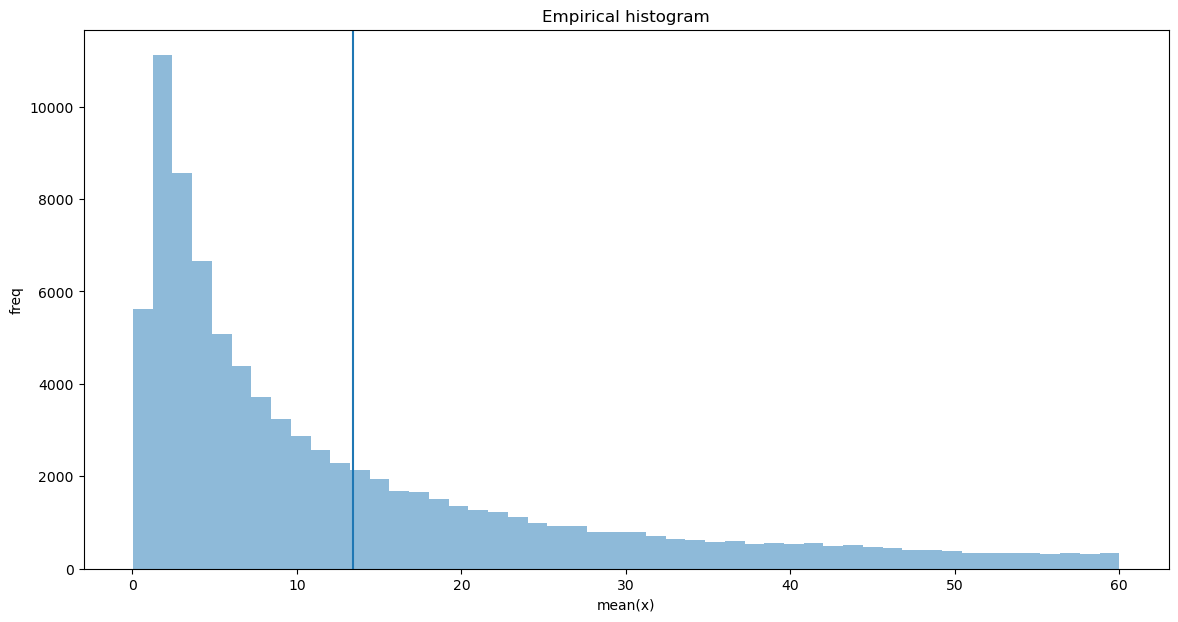

In [20]:
_, ax = plt.subplots(figsize = (14, 7))
plt.hist(airlines['res_time'], bins = 50, alpha = 0.5)
ax.axvline(airlines['res_time'].mean())
ax.set(title = 'Empirical histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

### Simulated Plot

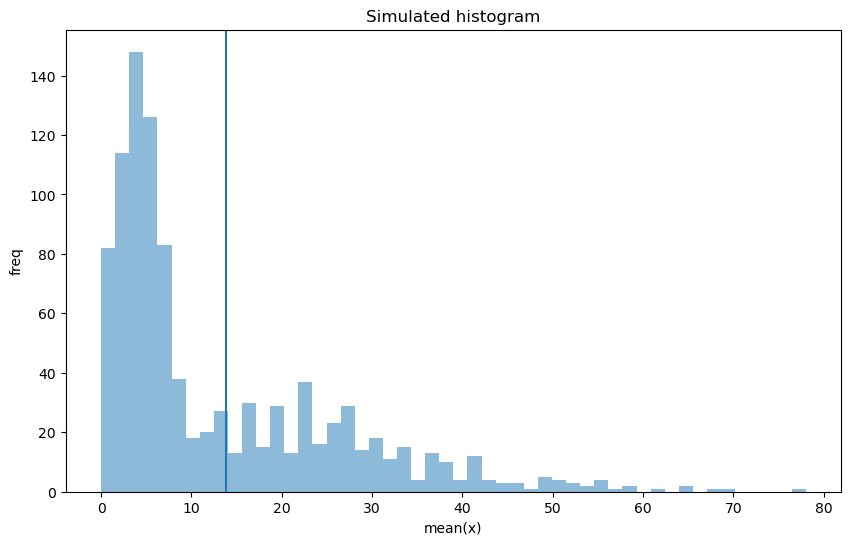

In [22]:
final_data = total[(total >= 0) & (total <= 80)]
data = np.random.choice(final_data.flatten(), size=1000, replace=False)

# Plot the cleaned data as a histogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(data.flatten(), bins=50, alpha=0.5)
ax.axvline(np.mean(final_data))
ax.set(title = 'Simulated histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')
plt.show()

### Verification with actual mean !

In [23]:
airlines['res_time'].mean()

13.436461105326302

# 2. Question 2
Each airline appears to have a different response time mean, which also differ if they were written on the weekend or on a work week day:

In [24]:
airlines.groupby(['author_id_y', 'created_at_y_is_weekend'])['res_time'].mean()

author_id_y      created_at_y_is_weekend
AirAsiaSupport   0                          23.472410
                 1                          20.694675
AlaskaAir        0                           6.624140
                 1                           5.630935
AmericanAir      0                          15.114572
                 1                          15.937899
British_Airways  0                          25.866365
                 1                          25.710606
Delta            0                          13.674155
                 1                          19.382936
JetBlue          0                           5.594833
                 1                           5.418759
SouthwestAir     0                          10.887163
                 1                          11.220752
VirginAmerica    0                           6.534827
                 1                           5.302918
VirginAtlantic   0                          17.487750
                 1                       

In [17]:
airlines.groupby('created_at_y_day_of_week')['res_time'].mean()

created_at_y_day_of_week
Friday       13.836451
Monday       13.457364
Saturday     14.508340
Sunday       14.996341
Thursday     12.550116
Tuesday      13.376829
Wednesday    11.924251
Name: res_time, dtype: float64

In [18]:
airlines.groupby('created_at_y_is_weekend')['res_time'].mean()

created_at_y_is_weekend
0    13.028558
1    14.761335
Name: res_time, dtype: float64

The mean of the response word count however seems to be pretty similar across airlines: 

In [19]:
airlines.groupby(['author_id_y', 'created_at_y_is_weekend'])['word_count'].mean()

author_id_y      created_at_y_is_weekend
AirAsiaSupport   0                          18.040323
                 1                          18.160681
AlaskaAir        0                          15.501401
                 1                          15.226138
AmericanAir      0                          18.576909
                 1                          18.634488
British_Airways  0                          20.998643
                 1                          21.187779
Delta            0                          18.235353
                 1                          18.322811
JetBlue          0                          16.463764
                 1                          17.018355
SouthwestAir     0                          20.531087
                 1                          20.946030
VirginAmerica    0                          15.188312
                 1                          15.175055
VirginAtlantic   0                          17.323657
                 1                       

The `word_count` mean and variance however are very different:

In [20]:
airlines.groupby(['author_id_y', 'created_at_y_is_weekend'])['word_count'].agg(['mean', 'var'])

mean        var
author_id_y     created_at_y_is_weekend                      
AirAsiaSupport  0                        18.040323  27.203802
                1                        18.160681  40.006330
AlaskaAir       0                        15.501401  47.063517
                1                        15.226138  46.095775
AmericanAir     0                        18.576909  28.035661
                1                        18.634488  27.118236
British_Airways 0                        20.998643  68.150745
                1                        21.187779  75.979612
Delta           0                        18.235353  67.589541
                1                        18.322811  71.221825
JetBlue         0                        16.463764  83.450360
                1                        17.018355  87.090772
SouthwestAir    0                        20.531087  49.954286
                1                        20.946030  49.019399
VirginAmerica   0                        15.188312  40.601293
                1                        15.175055  42.464903
VirginAtlantic  0                        17.323657  56.583686
                1                        18.686695  59.971900

# Hint: The Negative binomial distribution
A [Negative binomial](https://modelassist.epixanalytics.com/display/EA/Negative+Binomial) likelihood is used to model count data for which the variance is higher than the mean. 

The negative Binomial distribution has very similar characteristics to the Poisson distribution except that it has *two* parameters $\mu$ and $\alpha$, which enables it to vary variance independently of the mean. 

Recall that the Poisson distribution has one parameter, the expectation, that represents both its mean and its variance.

The Negative Binomial distribution estimates the total number of trials there will be before s successes are achieved where there is a probability p of success with each trial. The total number of trials is equal to the number of failures plus the s successes.

The negative binomial distribution describes a Poisson random variable whose rate parameter is not constant, but gamma distributed.

More specifically, the NegBinomial distribution has two applications for a binomial process:

- The total number of trials n in order to achieve s successes = NegBinomial(p,s);
- The total number of trials there might have been when we have observed s successes = NegBinomial(p,s+1)-1

The first use is when we know that we will stop at the sth success. The second is when we only know that there had been a certain number of successes.

>For example, a hospital has received a total of 17 people with a rare disease in the last month. The disease has a long incubation period. There have been no new admissions for this disease for a fair number of days. The hospital knows that people infected with this problem have a 65% chance of showing symptoms. It is also known that all people with symptoms will turn up at the hospital. How many other infected people are there out in the community? The answer is NegBinomial(65%,17+1)-(17+1). IF we knew (we don't) that the last person to be infected was symptomatic, the answer would be NegBinomial(65%,17) - 17. The total number infected would be NegBinomial(65%,17+1) -1.

The Negative Binomial distribution is frequently used in accident statistics and other Poisson processes because the Negative Binomial distribution can be derived as a Poisson random variable whose rate parameter lambda is itself random and Gamma distributed, i.e.:
```
Poisson(Gamma(0,b,a)) = NegBinomial(1/(b+1),a) - a
```

## Homework Question 2
Build a model of the response word count distribution for all airlines, knowing that the mean and variance for that distribution are very unequal. From the model, generate a posterior predictive distribution (simulated data), and compare with the empirical data. Is your model a good one?

### Wordcount For Weekdays

### For Weekdays ! (created_at_y_is_weekend==0)

In [25]:
df1 = airlines.loc[airlines['created_at_y_is_weekend'] == 0]

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


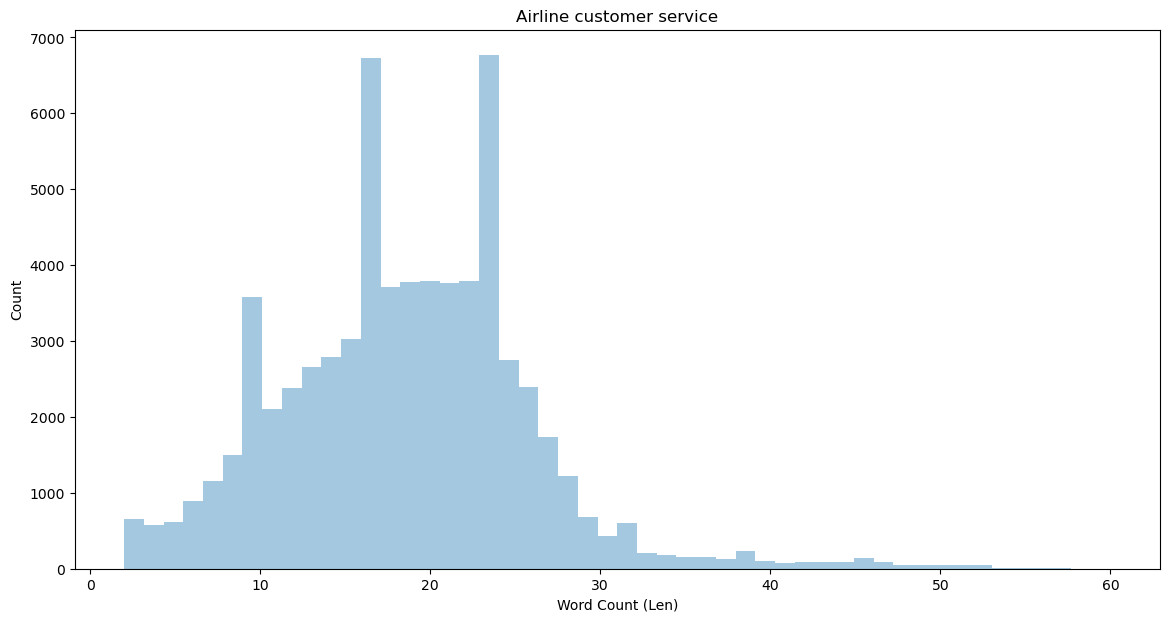

In [26]:
plt.figure(figsize = (14, 7))
sns.distplot(df1['word_count'], kde = False)
plt.title('Airline customer service')
plt.xlabel('Word Count (Len)')
plt.ylabel('Count');

In [27]:
with pm.Model() as model4:
    alpha = pm.HalfNormal('alpha', sigma=10)
    nu = pm.HalfNormal('nu', sigma=10)
    
    
    nb = pm.NegativeBinomial('nb', mu = alpha, alpha = nu, observed=df1['word_count']) 

In [28]:
with model4:
    trace1 = pm.sample(2000, tune=2000)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 69 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


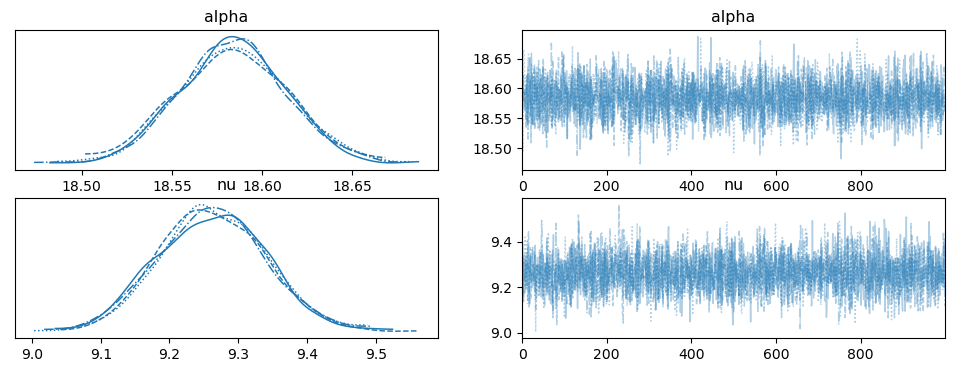

In [29]:
az.plot_trace(trace1[:1000], var_names = ['alpha','nu']);

In [30]:
ppc1 = pm.sample_posterior_predictive(trace1, samples = 1000, model = model4)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [31]:
ppc1

{'nb': array([[31, 19,  5, ..., 16, 11, 22],
        [22, 15, 20, ..., 13, 38, 15],
        [16, 14, 29, ..., 15, 14, 15],
        ...,
        [48, 30, 25, ..., 18, 33,  7],
        [31, 12, 17, ..., 24,  6, 28],
        [21, 15, 17, ..., 22, 18, 18]])}

### Empirical Plot

[Text(0.5, 1.0, 'Empirical histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

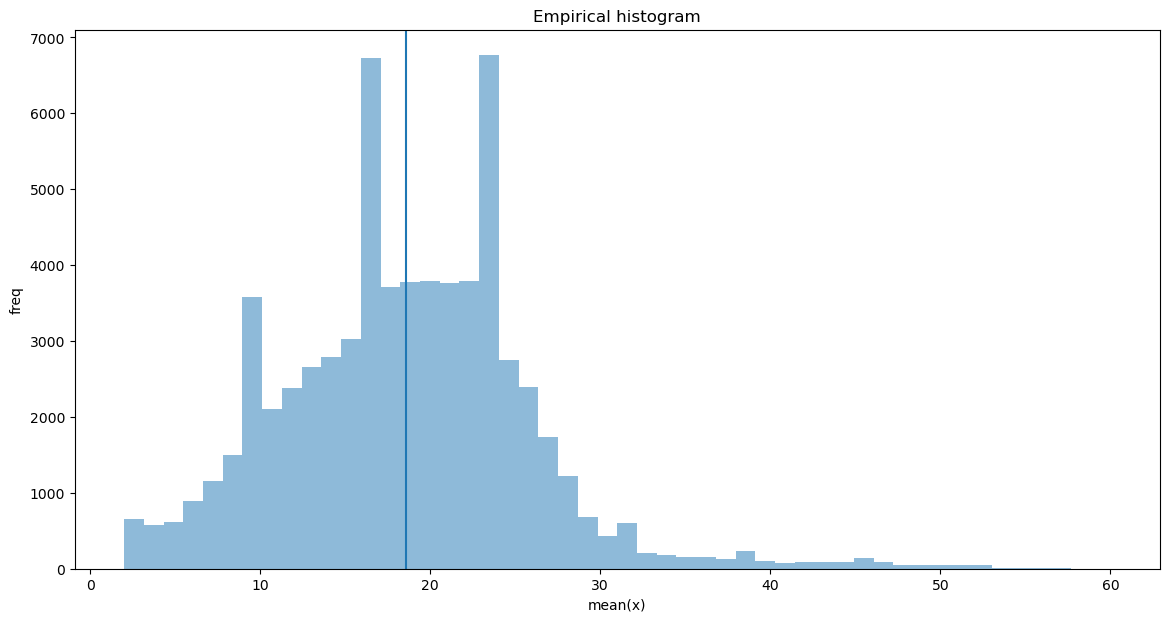

In [32]:
_, ax = plt.subplots(figsize = (14, 7))
plt.hist(df1['word_count'], bins = 50, alpha = 0.5)
ax.axvline(df1['word_count'].mean())
ax.set(title = 'Empirical histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

### Simulated Plot

[Text(0.5, 1.0, 'Simulated histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

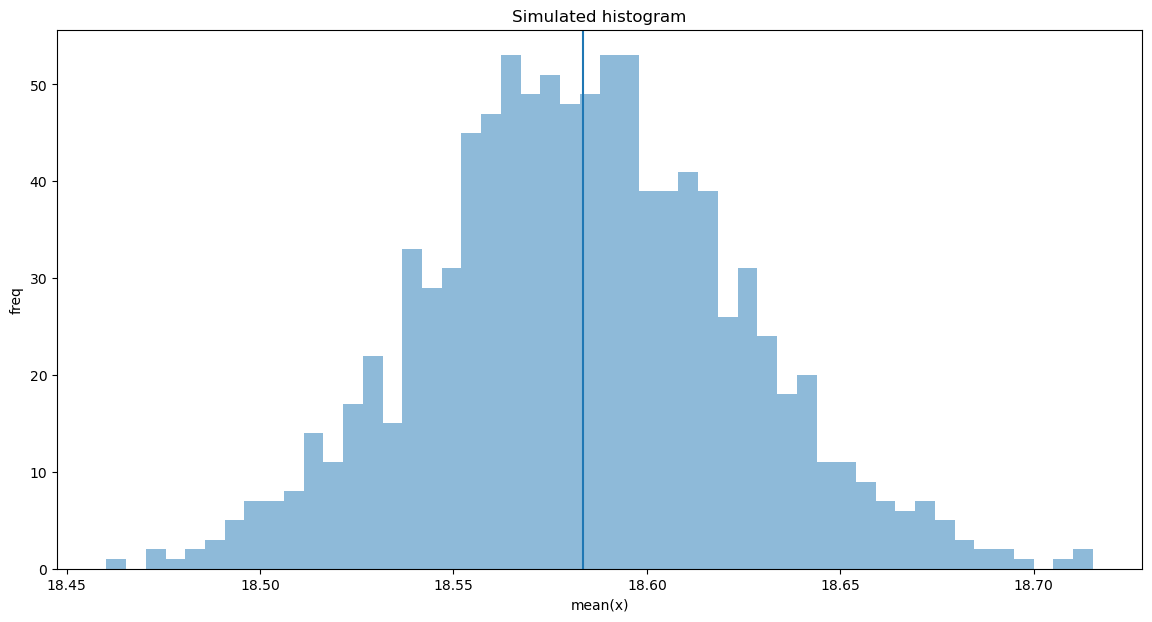

In [33]:
_, ax = plt.subplots(figsize = (14, 7))

ax.hist([n.mean() for n in ppc1['nb']], bins = 50, alpha = 0.5)
ax.axvline(df1['word_count'].mean())
ax.set(title = 'Simulated histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

### Verfiication with actual mean!!

In [34]:
df1['word_count'].mean()

18.583469523636584

### For Weekdays ! (created_at_y_is_weekend==1)¶

In [35]:
df2 = airlines.loc[airlines['created_at_y_is_weekend'] == 1]

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


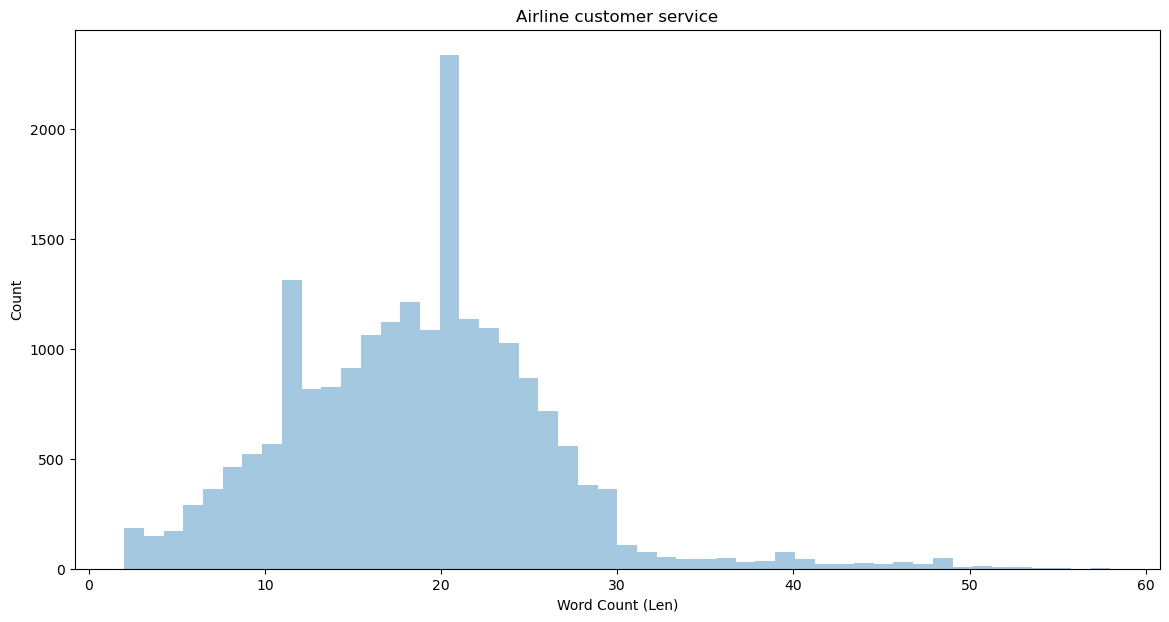

In [36]:
plt.figure(figsize = (14, 7))
sns.distplot(df2['word_count'], kde = False)
plt.title('Airline customer service')
plt.xlabel('Word Count (Len)')
plt.ylabel('Count');

In [37]:
with pm.Model() as model5:
    alpha = pm.HalfNormal('alpha', sigma=10)
    nu = pm.HalfNormal('nu', sigma=10)
    
    
    nb1 = pm.NegativeBinomial('nb', mu = alpha, alpha = nu, observed=df2['word_count']) 

In [38]:
with model5:
    trace2 = pm.sample(2000, tune=2000)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 36 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


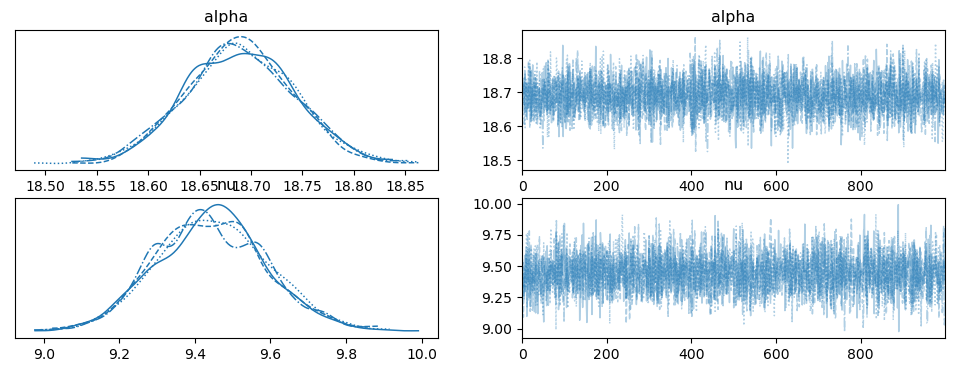

In [39]:
az.plot_trace(trace2[:1000], var_names = ['alpha','nu']);

In [41]:
ppc2 = pm.sample_posterior_predictive(trace2, samples = 1000, model = model5)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [42]:
ppc2

{'nb': array([[ 7, 25, 14, ..., 18, 16, 16],
        [28, 19, 12, ..., 19, 18, 19],
        [13, 18, 29, ..., 23, 24, 28],
        ...,
        [ 9, 23, 24, ..., 26, 29, 24],
        [37, 23, 22, ..., 26, 24, 17],
        [31, 15, 18, ..., 18, 13, 15]])}

[Text(0.5, 1.0, 'Empirical histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

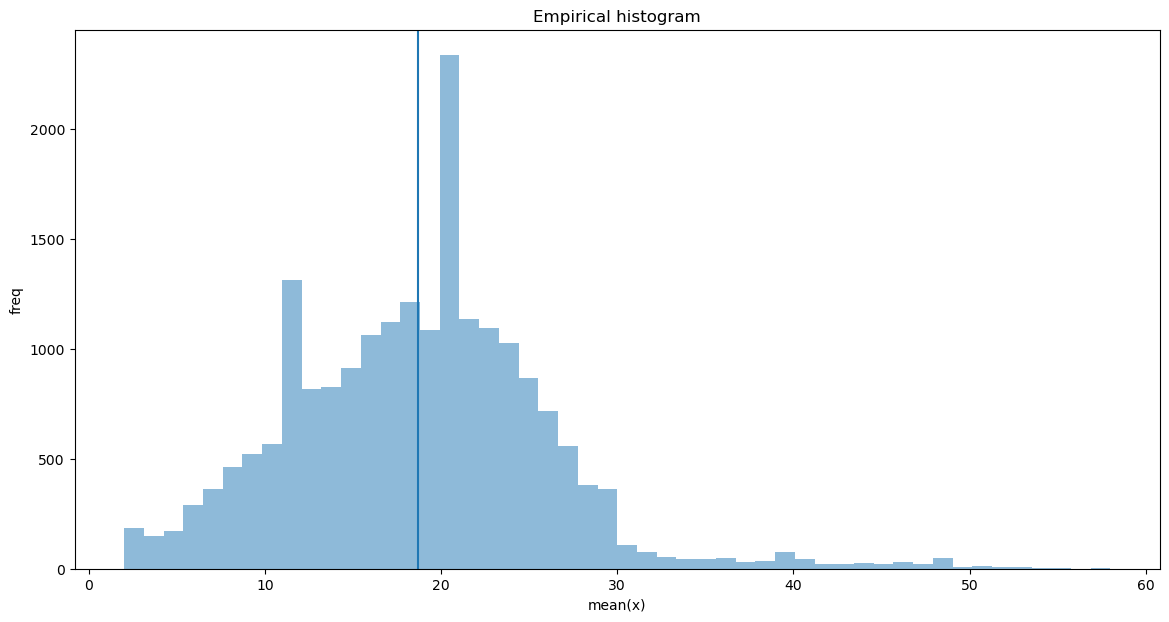

In [43]:
_, ax = plt.subplots(figsize = (14, 7))
plt.hist(df2['word_count'], bins = 50, alpha = 0.5)
ax.axvline(df2['word_count'].mean())
ax.set(title = 'Empirical histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

[Text(0.5, 1.0, 'Simulated histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

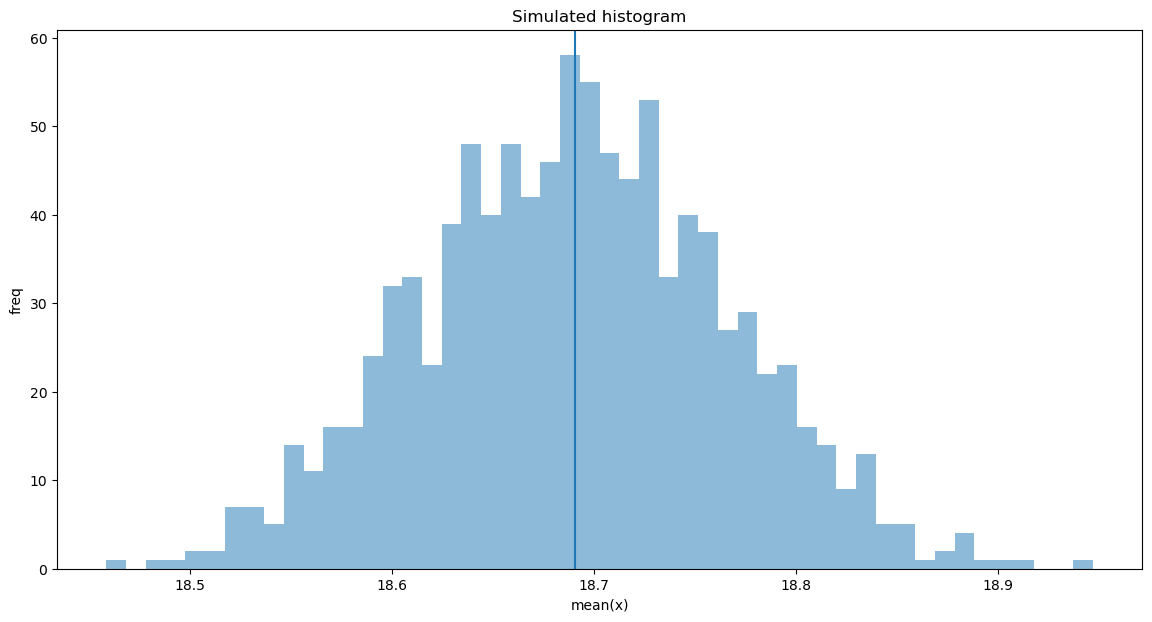

In [44]:
_, ax = plt.subplots(figsize = (14, 7))

ax.hist([n.mean() for n in ppc2['nb']], bins = 50, alpha = 0.5)
ax.axvline(df2['word_count'].mean())
ax.set(title = 'Simulated histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

### Verification with actual mean!

In [45]:
df2['word_count'].mean()

18.690602575444807